In [75]:
!pip install tensorflow 


[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [76]:
!pip install opencv-python matplotlib


[notice] A new release of pip is available: 23.1.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [78]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [41]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        

cap.release()

cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame)

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg')
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg')
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg')
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\02dba47c-87a5-11ee-af4f-701ab844fa83.jpg'


In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img
img = preprocess('data\\anchor\\ebe36c56-87a4-11ee-b4de-701ab844fa83.jpg')

In [13]:
img.numpy().max() 

0.8093137

In [14]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()

exampple = samples.next()

exampple

(b'data\\anchor\\02dba47c-87a5-11ee-af4f-701ab844fa83.jpg',
 b'data\\positive\\e31dc032-87a5-11ee-8528-701ab844fa83.jpg',
 1.0)

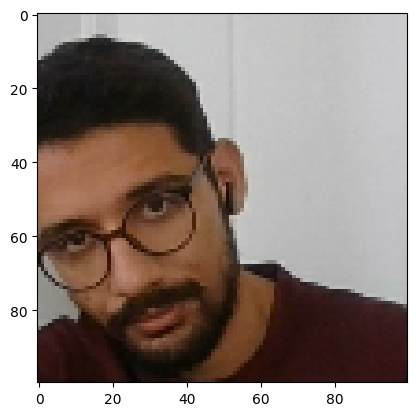

In [15]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [16]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

# Training partition
train_data = data.take(round(len(data)))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [17]:
len(train_data)

5

In [18]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()

In [20]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [21]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()


In [22]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(1e-4)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [25]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]

X

(array([[[[0.7088235 , 0.7088235 , 0.7088235 ],
          [0.7144608 , 0.7144608 , 0.7144608 ],
          [0.7127451 , 0.7127451 , 0.7127451 ],
          ...,
          [0.78333336, 0.78333336, 0.7911765 ],
          [0.7872549 , 0.7872549 , 0.79509807],
          [0.78431374, 0.78431374, 0.7921569 ]],
 
         [[0.70392156, 0.70392156, 0.70392156],
          [0.7127451 , 0.7127451 , 0.7127451 ],
          [0.7198529 , 0.7198529 , 0.7198529 ],
          ...,
          [0.7794118 , 0.7794118 , 0.7872549 ],
          [0.7823529 , 0.7823529 , 0.79019606],
          [0.7970588 , 0.7970588 , 0.80490196]],
 
         [[0.70392156, 0.70392156, 0.70392156],
          [0.70906866, 0.70906866, 0.70906866],
          [0.71666664, 0.71666664, 0.71666664],
          ...,
          [0.78333336, 0.78333336, 0.7911765 ],
          [0.7757353 , 0.7757353 , 0.78357846],
          [0.7801471 , 0.7801471 , 0.7879902 ]],
 
         ...,
 
         [[0.19975491, 0.12009804, 0.12352941],
          [0.20906

In [26]:
y

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [27]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [52]:
from tensorflow.keras.metrics import Precision, Recall

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [53]:
EPOCHS = 50

In [54]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 20s 3s/step
0.5121728 0.5 1.0

 Epoch 2/50
5/5 [==============================] - 12s 2s/step
0.58082306 0.47058824 1.0

 Epoch 3/50
5/5 [==============================] - 13s 2s/step
0.4780842 0.61764705 1.0

 Epoch 4/50
5/5 [==============================] - 13s 2s/step
0.49934256 0.7941176 1.0

 Epoch 5/50
5/5 [==============================] - 13s 2s/step
0.19529983 1.0 1.0

 Epoch 6/50
5/5 [==============================] - 13s 2s/step
0.08492856 1.0 1.0

 Epoch 7/50
5/5 [==============================] - 13s 2s/step
0.1270492 1.0 1.0

 Epoch 8/50
5/5 [==============================] - 12s 2s/step
0.06157504 1.0 1.0

 Epoch 9/50
5/5 [==============================] - 12s 2s/step
0.009874463 1.0 1.0

 Epoch 10/50
5/5 [==============================] - 12s 2s/step
0.007626727 1.0 

5/5 [==============================] - 4s 821ms/step
0.00024261161 1.0 1.0

 Epoch 24/50
5/5 [==============================] - 4s 784ms/step
0.00094476575 1.0 1.0

 Epoch 25/50
5/5 [==============================] - 4s 798ms/step
0.00044425268 1.0 1.0

 Epoch 26/50
5/5 [==============================] - 4s 856ms/step
0.0010003357 1.0 1.0

 Epoch 27/50
5/5 [==============================] - 4s 868ms/step
0.00012172862 1.0 1.0

 Epoch 28/50
5/5 [==============================] - 5s 879ms/step
0.0011789724 1.0 1.0

 Epoch 29/50
5/5 [==============================] - 5s 910ms/step
0.00037537608 1.0 1.0

 Epoch 30/50
5/5 [==============================] - 5s 887ms/step
5.11151e-05 1.0 1.0

 Epoch 31/50
5/5 [==============================] - 5s 894ms/step
6.293346e-05 1.0 1.0

 Epoch 32/50
5/5 [==============================] - 5s 893ms/step
9.1819544e-05 1.0 1.0

 Epoch 33/50
5/5 [==============================] - 4s 872ms/step
0.00051263673 1.0 1.0

 Epoch 34/50
5/5 [=====================

5/5 [==============================] - 4s 875ms/step
0.000121159166 1.0 1.0

 Epoch 47/50
5/5 [==============================] - 4s 873ms/step
7.3079456e-05 1.0 1.0

 Epoch 48/50
5/5 [==============================] - 4s 877ms/step
6.816266e-05 1.0 1.0

 Epoch 49/50
5/5 [==============================] - 4s 881ms/step
0.00019880975 1.0 1.0

 Epoch 50/50
5/5 [==============================] - 4s 854ms/step
0.00023621293 1.0 1.0


In [29]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [30]:
len(test_val)

16

In [250]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 420ms/step


In [251]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]

In [252]:
y_true

array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [253]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 137ms/step
1.0 1.0


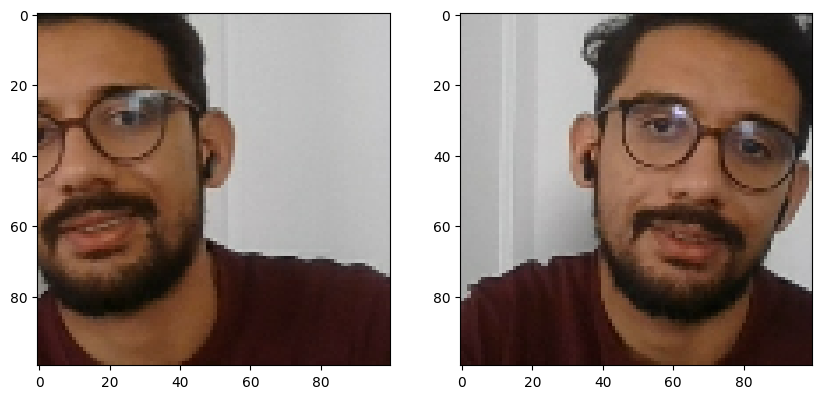

In [32]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [33]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [34]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [35]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[0.50003743],
       [0.4977755 ],
       [0.49961916],
       [0.4983905 ],
       [0.4980222 ],
       [0.5002305 ],
       [0.50021195],
       [0.49907416],
       [0.49969628],
       [0.49910778],
       [0.4990304 ],
       [0.49969003],
       [0.49949378],
       [0.4989419 ],
       [0.49614954],
       [0.5000673 ]], dtype=float32)

In [36]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [37]:
os.listdir(os.path.join('application_data', 'verification_images'))

['c248d7f3-87a5-11ee-b1cc-701ab844fa83.jpg',
 'c92ab1d1-87a5-11ee-8b84-701ab844fa83.jpg',
 'c94eb93f-87a5-11ee-bcbe-701ab844fa83.jpg',
 'cae46a4a-87a5-11ee-bc7b-701ab844fa83.jpg',
 'cb0f680c-87a5-11ee-8a93-701ab844fa83.jpg',
 'ccfc26e3-87a5-11ee-99a0-701ab844fa83.jpg',
 'ce40a565-87a5-11ee-baf4-701ab844fa83.jpg',
 'cea34ac8-87a5-11ee-9c4b-701ab844fa83.jpg',
 'cee9bf2b-87a5-11ee-9f2f-701ab844fa83.jpg',
 'd4e8a309-87a5-11ee-91bb-701ab844fa83.jpg',
 'd5374be8-87a5-11ee-91c7-701ab844fa83.jpg',
 'd58d414a-87a5-11ee-bb21-701ab844fa83.jpg',
 'd5c6bceb-87a5-11ee-a616-701ab844fa83.jpg',
 'e31dc032-87a5-11ee-8528-701ab844fa83.jpg',
 'e38ec621-87a5-11ee-8a85-701ab844fa83.jpg',
 'e3ab1967-87a5-11ee-ac25-701ab844fa83.jpg',
 'e4c743a2-87a5-11ee-9bdc-701ab844fa83.jpg',
 'e9a21362-87a5-11ee-8871-701ab844fa83.jpg']

In [38]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [39]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\c248d7f3-87a5-11ee-b1cc-701ab844fa83.jpg
application_data\verification_images\c92ab1d1-87a5-11ee-8b84-701ab844fa83.jpg
application_data\verification_images\c94eb93f-87a5-11ee-bcbe-701ab844fa83.jpg
application_data\verification_images\cae46a4a-87a5-11ee-bc7b-701ab844fa83.jpg
application_data\verification_images\cb0f680c-87a5-11ee-8a93-701ab844fa83.jpg
application_data\verification_images\ccfc26e3-87a5-11ee-99a0-701ab844fa83.jpg
application_data\verification_images\ce40a565-87a5-11ee-baf4-701ab844fa83.jpg
application_data\verification_images\cea34ac8-87a5-11ee-9c4b-701ab844fa83.jpg
application_data\verification_images\cee9bf2b-87a5-11ee-9f2f-701ab844fa83.jpg
application_data\verification_images\d4e8a309-87a5-11ee-91bb-701ab844fa83.jpg
application_data\verification_images\d5374be8-87a5-11ee-91c7-701ab844fa83.jpg
application_data\verification_images\d58d414a-87a5-11ee-bb21-701ab844fa83.jpg
application_data\verification_images\d5c6bceb-87a5-11ee-a616-701

In [40]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [58]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.8, 0.65)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 40ms/step
True


In [59]:
np.squeeze(results)> 0.9

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True])

In [60]:
results

[array([[0.99999475]], dtype=float32),
 array([[0.99999946]], dtype=float32),
 array([[0.99999523]], dtype=float32),
 array([[0.99353707]], dtype=float32),
 array([[0.90794337]], dtype=float32),
 array([[0.999893]], dtype=float32),
 array([[0.9958242]], dtype=float32),
 array([[0.8627607]], dtype=float32),
 array([[0.9633963]], dtype=float32),
 array([[0.99999577]], dtype=float32),
 array([[0.99098736]], dtype=float32),
 array([[0.70352244]], dtype=float32),
 array([[0.9149972]], dtype=float32),
 array([[0.9980224]], dtype=float32),
 array([[0.90572435]], dtype=float32),
 array([[0.9198535]], dtype=float32),
 array([[0.9999164]], dtype=float32),
 array([[0.9890063]], dtype=float32)]